# Data loading

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

# 1. Load Target Data and tabular data

df_app = pd.read_csv("application_train.csv")
target_df = df_app[['SK_ID_CURR', 'TARGET']]
print("Loaded application_train.csv, shape:", df_app.shape)

# 2.1 Installments Payments
df_inst = pd.read_csv("installments_payments.csv", encoding="ISO-8859-1")
print("Loaded installments_payments.csv, shape:", df_inst.shape)

# 2.2 Previous Applications
df_prev = pd.read_csv("previous_application.csv", encoding="ISO-8859-1")
print("Loaded previous_application.csv, shape:", df_prev.shape)

# 2.3 credit card balance
df_ccb = pd.read_csv("credit_card_balance.csv", encoding="ISO-8859-1")
print("Loaded credit_card_balance.csv, shape:", df_ccb.shape)

# 2.4 bureau
df_b = pd.read_csv("bureau.csv", encoding="ISO-8859-1")
print("Loaded bureau.csv, shape:", df_b.shape)

# 2.5 bureau balance
df_bb = pd.read_csv("bureau_balance.csv", encoding="ISO-8859-1")
print("Loaded bureau_balance.csv, shape:", df_bb.shape)

D:\download\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loaded application_train.csv, shape: (307511, 122)
Loaded installments_payments.csv, shape: (13605401, 8)
Loaded previous_application.csv, shape: (1670214, 37)
Loaded credit_card_balance.csv, shape: (3840312, 23)
Loaded bureau.csv, shape: (1716428, 17)
Loaded bureau_balance.csv, shape: (27299925, 3)


# Logistic and XGBoost & feature engineering

In [2]:
def preprocess_application(df):
    """
    1. Handle anomalies in DAYS_EMPLOYED
    2. Create ratio features
    3. Remove multi‑outliers
    4. One‑hot encode low‑cardinality numerics & categoricals
    5. Special binning for EXT_SOURCE_2 and EXT_SOURCE_3
    """
    df = df.copy()
    df.drop('TARGET', axis = 1, inplace = True)
    # --- 1) Anomaly flags & basic cleaning --------------------
    # CODE_GENDER: treat 'XNA' as missing
    df['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
    
    # DAYS_EMPLOYED anomaly
    df['DAYS_EMPLOYED_anom'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)
    df.loc[df['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan
    
    # --- 2) Ratio features -------------------------------------
    df['EMPLOYED_BIRTH_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC']   = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON']    = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC']  = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE']         = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    # --- 3) Remove extreme multi‑outliers ---------------------
    # Define numeric features
    num_feats = df.select_dtypes(include=['int64','float64']).columns
    # Collect indices of rows that are outliers in >2 features
    from collections import Counter
    outlier_counts = Counter()
    
    for col in num_feats:
        # only consider real values
        col_series = df[col].dropna()
        q1, q3 = col_series.quantile([0.02, 0.98])
        iqr = q3 - q1
        mask = (df[col] < (q1 - 1.5*iqr)) | (df[col] > (q3 + 1.5*iqr))
        outlier_counts.update(df[mask].index.tolist())
    
    multi_outliers = [idx for idx,count in outlier_counts.items() if count > 2]
    df.drop(index=multi_outliers, inplace=True)
    
    # --- 4) One‑hot encoding -------------------------------
    # split numeric into low/high cardinality
    nunique = df[num_feats].nunique()
    low_card_num  = nunique[nunique <= 150].index.tolist()
    high_card_num = nunique[nunique > 150].index.tolist()
    
    # categorical features
    cat_feats = df.select_dtypes(include=['object']).columns.tolist()
    
    # one‑hot low‑cardinal numerics + categoricals
    df = pd.get_dummies(df, columns=low_card_num + cat_feats, dummy_na=True)
    
    # --- 5) EXT_SOURCE binning -----------------------------
    # for EXT_SOURCE_2
    ext2_counts = df['EXT_SOURCE_2'].value_counts()
    top2 = ext2_counts[ext2_counts > 100].index
    for val in top2:
        df[f'EXT_SOURCE_2_{val}'] = (df['EXT_SOURCE_2'] == val).astype(int)
    
    # for EXT_SOURCE_3
    ext3_counts = df['EXT_SOURCE_3'].value_counts()
    top3 = ext3_counts[ext3_counts > 1000].index
    for val in top3:
        df[f'EXT_SOURCE_3_{val}'] = (df['EXT_SOURCE_3'] == val).astype(int)
    
    # drop originals if you like
    df.drop(columns=['EXT_SOURCE_2','EXT_SOURCE_3'], inplace=True)
    
    return df

# === Usage ===
#df_app = preprocess_application(df_app)
#print("After preprocessing:", df_app.shape)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Extract target before preprocessing
target = target_df

# 2. Preprocess application features
df_app_clean = preprocess_application(df_app)

# 3. Merge target back in
df_app_clean = df_app_clean.merge(target, on='SK_ID_CURR')

# 4. Define X and y
y = df_app_clean['TARGET'].values
X = df_app_clean.drop(columns=['SK_ID_CURR', 'TARGET'])

# 5. Train-test split BEFORE any imputation or resampling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6. Impute and scale
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# (Optional) 7. Apply ROS only on training set (if needed):
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=42)
# X_train_scaled, y_train = ros.fit_resample(X_train_scaled, y_train)

# 8. Train model
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

# 9. Predict
y_pred_prob = clf.predict_proba(X_test_scaled)[:, 1]
y_pred_class = clf.predict(X_test_scaled)

# 10. Metrics
auc = roc_auc_score(y_test, y_pred_prob)
logloss = log_loss(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred_class)

C:\Users\20004\AppData\Local\Temp\ipykernel_23704\3299981099.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
C:\Users\20004\AppData\Local\Temp\ipykernel_23704\3299981099.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'EXT_SOURCE_

In [4]:
auc

0.6903027488455213

              precision    recall  f1-score   support

  No Default       0.95      0.65      0.77     56049
     Default       0.14      0.64      0.23      4927

    accuracy                           0.65     60976
   macro avg       0.55      0.64      0.50     60976
weighted avg       0.89      0.65      0.73     60976



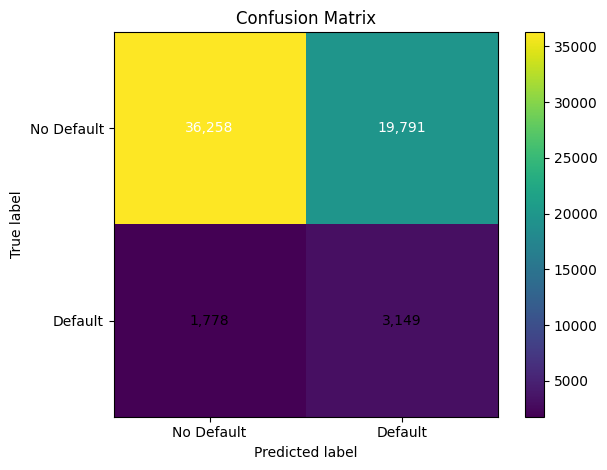

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Print classification report
print(classification_report(
    y_test,
    y_pred_class,
    target_names=['No Default', 'Default']
))

# 2. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# 3. Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=[0, 1],
    yticks=[0, 1],
    xticklabels=['No Default', 'Default'],
    yticklabels=['No Default', 'Default'],
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix'
)

# 4. Annotate counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            f"{cm[i, j]:,}",
            ha='center',
            va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

                             feature      coef
3                    AMT_GOODS_PRICE -1.156656
1                         AMT_CREDIT  0.801693
8                       EXT_SOURCE_1 -0.207057
47                      PAYMENT_RATE -0.197830
578  NONLIVINGAPARTMENTS_MODE_0.0973 -0.189381
2                        AMT_ANNUITY  0.187202
888    OBS_30_CNT_SOCIAL_CIRCLE_17.0 -0.170362
21                 NONLIVINGAREA_AVG  0.161368
10                  BASEMENTAREA_AVG -0.160298
546            FLOORSMIN_MODE_0.7917 -0.158339
931    OBS_60_CNT_SOCIAL_CIRCLE_17.0  0.156130
41            DAYS_LAST_PHONE_CHANGE  0.154874
9                     APARTMENTS_AVG -0.147368
35                   COMMONAREA_MEDI -0.139112
930    OBS_60_CNT_SOCIAL_CIRCLE_16.0  0.133939
38                   LIVINGAREA_MEDI -0.132759
247  REGION_RATING_CLIENT_W_CITY_1.0 -0.130359
887    OBS_30_CNT_SOCIAL_CIRCLE_16.0 -0.129511
537            FLOORSMIN_MODE_0.4167 -0.128263
509            FLOORSMAX_MODE_0.3333 -0.124251


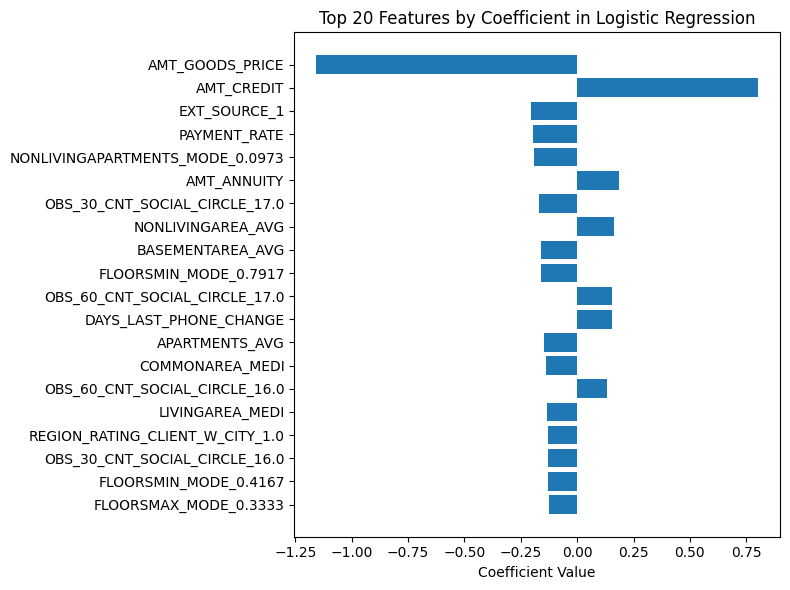

In [6]:
feature_names = X_train.columns
coefficients = clf.coef_[0]

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'coef': coefficients,
    'abs_coef': np.abs(coefficients)
})


feat_imp_sorted = feat_imp.sort_values('abs_coef', ascending=False)

top20 = feat_imp_sorted.head(20)
print(top20[['feature', 'coef']])

plt.figure(figsize=(8, 6))
plt.barh(top20['feature'], top20['coef'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Features by Coefficient in Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    confusion_matrix,
    roc_curve,
    ConfusionMatrixDisplay,
    classification_report
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

# 1. Extract target before preprocessing
target = target_df

# 2. Preprocess application features
df_app_clean = preprocess_application(df_app)

# 3. Merge target back in
df_app_clean = df_app_clean.merge(target, on='SK_ID_CURR')

# 4. Define X and y
y = df_app_clean['TARGET'].values
X = df_app_clean.drop(columns=['SK_ID_CURR', 'TARGET'])

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 6. Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# 7. (Optional) Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)

# 8. Compute scale_pos_weight for class imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# 9. Initialize XGBClassifier
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)

# 10. Fit with early stopping
xgb_clf.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    eval_metric=['auc', 'logloss'],
    early_stopping_rounds=5,
    verbose=True
)

# 11. Predictions
y_pred_prob  = xgb_clf.predict_proba(X_test_scaled)[:, 1]
y_pred_class = xgb_clf.predict(X_test_scaled)

# 12. Metrics
auc      = roc_auc_score(y_test, y_pred_prob)
logloss  = log_loss(y_test, y_pred_prob)
conf_mat = confusion_matrix(y_test, y_pred_class)

C:\Users\20004\AppData\Local\Temp\ipykernel_21096\3299981099.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
C:\Users\20004\AppData\Local\Temp\ipykernel_21096\3299981099.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'EXT_SOURCE_

[0]	validation_0-auc:0.66359	validation_0-logloss:0.68903	validation_1-auc:0.64866	validation_1-logloss:0.68913
[1]	validation_0-auc:0.67490	validation_0-logloss:0.68509	validation_1-auc:0.65898	validation_1-logloss:0.68532
[2]	validation_0-auc:0.67559	validation_0-logloss:0.68163	validation_1-auc:0.65963	validation_1-logloss:0.68197
[3]	validation_0-auc:0.67881	validation_0-logloss:0.67846	validation_1-auc:0.66132	validation_1-logloss:0.67894
[4]	validation_0-auc:0.67952	validation_0-logloss:0.67543	validation_1-auc:0.66230	validation_1-logloss:0.67600
[5]	validation_0-auc:0.68094	validation_0-logloss:0.67274	validation_1-auc:0.66356	validation_1-logloss:0.67348
[6]	validation_0-auc:0.68426	validation_0-logloss:0.67011	validation_1-auc:0.66646	validation_1-logloss:0.67096
[7]	validation_0-auc:0.68543	validation_0-logloss:0.66781	validation_1-auc:0.66703	validation_1-logloss:0.66882
[8]	validation_0-auc:0.68736	validation_0-logloss:0.66551	validation_1-auc:0.66842	validation_1-logloss:

In [4]:
auc

0.7124920935707539

              precision    recall  f1-score   support

  No Default       0.95      0.69      0.80     56049
     Default       0.15      0.63      0.24      4927

    accuracy                           0.68     60976
   macro avg       0.55      0.66      0.52     60976
weighted avg       0.89      0.68      0.75     60976



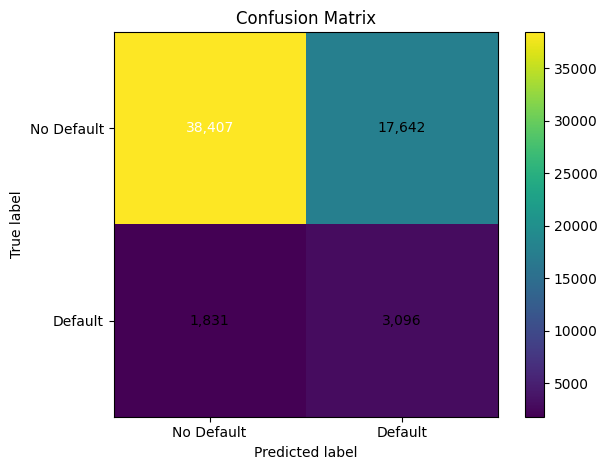

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Print classification report
print(classification_report(
    y_test,
    y_pred_class,
    target_names=['No Default', 'Default']
))

# 2. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# 3. Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=[0, 1],
    yticks=[0, 1],
    xticklabels=['No Default', 'Default'],
    yticklabels=['No Default', 'Default'],
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix'
)

# 4. Annotate counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            f"{cm[i, j]:,}",
            ha='center',
            va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

                                   feature  importance
1135  NAME_EDUCATION_TYPE_Higher education    0.024353
1109                         CODE_GENDER_M    0.015407
5                            DAYS_EMPLOYED    0.015402
8                             EXT_SOURCE_1    0.015303
249        REGION_RATING_CLIENT_W_CITY_3.0    0.014210
1132              NAME_INCOME_TYPE_Working    0.012988
247        REGION_RATING_CLIENT_W_CITY_1.0    0.011102
1245         HOUSETYPE_MODE_block of flats    0.010196
1111                        FLAG_OWN_CAR_N    0.009852
1257                EMERGENCYSTATE_MODE_No    0.009088
904           DEF_30_CNT_SOCIAL_CIRCLE_0.0    0.007913
959                    FLAG_DOCUMENT_3_0.0    0.007683
47                            PAYMENT_RATE    0.007601
1105         NAME_CONTRACT_TYPE_Cash loans    0.007424
245               REGION_RATING_CLIENT_3.0    0.006866
4                               DAYS_BIRTH    0.006639
1253              WALLSMATERIAL_MODE_Panel    0.006551
3         

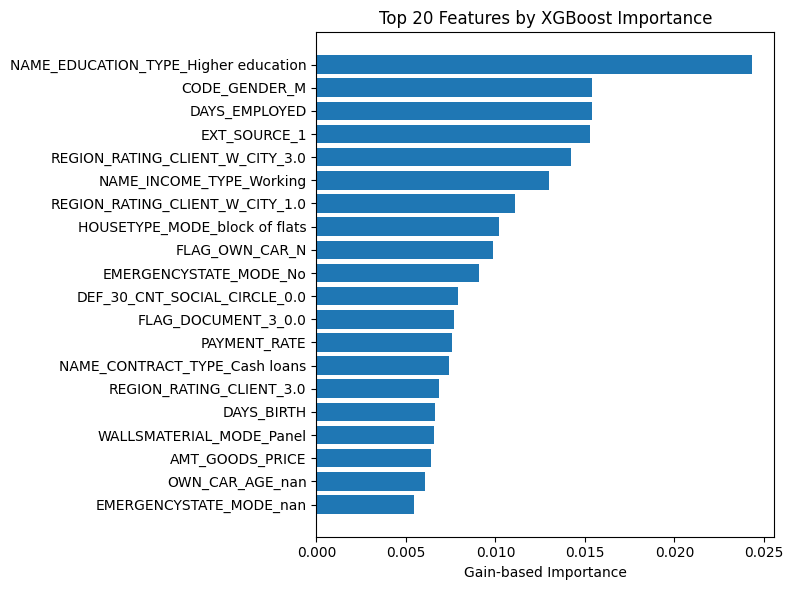

In [8]:
# 1. Extract the raw importance scores
importances = xgb_clf.feature_importances_  # shape: (n_features,)

# 2. Build a DataFrame
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# 3. Sort and select top 20
feat_imp_sorted = feat_imp.sort_values('importance', ascending=False)
top20 = feat_imp_sorted.head(20)

# 4. Print them
print(top20)

# 5. Plot
plt.figure(figsize=(8, 6))
plt.barh(top20['feature'], top20['importance'])
plt.xlabel('Gain-based Importance')
plt.title('Top 20 Features by XGBoost Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Deep learning model & Feature engineering

## Feature engineering

In [ ]:
def preprocess_df(df, scale_data=True, encode_categoricals=False, exclude_cols=None):
    """
    Preprocesses the DataFrame by:
      1. Dropping duplicate rows.
      2. Filling missing numeric values with the median.
      3. Filling missing categorical values with the mode (or "Unknown" if mode is not available).
      4. scaling numeric features, excluding any specified columns.
      5. one-hot encoding categorical features.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        scale_data (bool): Whether to scale numeric columns.
        encode_categoricals (bool): Whether to perform one-hot encoding on categorical columns.
        exclude_cols (list or None): List of column names to exclude from scaling (e.g., ID columns).
    
    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    
    if exclude_cols is None:
        exclude_cols = []
    
    # Drop duplicates
    df = df.drop_duplicates().copy()
    
    # Identify numeric and categorical columns.
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                    if col not in exclude_cols]
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Report missing value counts before imputation
    print("\nMissing values before imputation:")
    print(df.isnull().sum())
    
    # Fill missing numeric values with median
    for col in numeric_cols:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
    
    # Fill missing categorical values with mode if available, otherwise "Unknown"
    for col in categorical_cols:
        if not df[col].mode().empty:
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna("Unknown")
    
    # Report missing value counts after imputation
    print("\nMissing values after imputation:")
    print(df.isnull().sum())
    
    # scale numeric columns (do not scale columns in exclude_cols).
    if scale_data and numeric_cols:
        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    # one-hot encode categorical columns.
    if encode_categoricals and categorical_cols:
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    return df

In [ ]:
def cap_outliers(df, multiplier=1.5):
    """
    Caps numeric features in the dataframe using the IQR method.

    Parameters:
      df (pd.DataFrame): Input dataframe.
      multiplier (float): Multiplier for the IQR to determine thresholds.

    Returns:
      pd.DataFrame: DataFrame with outliers capped.
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Count and show number of outliers before capping
        outlier_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        print(f"{col}: {outlier_count} outliers detected (capping to [{lower_bound}, {upper_bound}])")
        
        # Cap values using DataFrame.clip()
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df

In [ ]:
def create_sequences(df, group_key, sort_by, features, max_length):
    """
    Constructs sequences for each unique entity defined by group_key.
    Sequences are sorted by the sort_by column and then padded/truncated to max_length.
    
    Parameters:
      df         : Input DataFrame.
      group_key  : Column used to group records (e.g., "SK_ID_CURR").
      sort_by    : Column to sort each group by (time indicator).
      features   : List of features to include in the sequence.
      max_length : Maximum number of time steps per sequence.
      
    Returns:
      padded_sequences: NumPy array of shape (num_groups, max_length, num_features).
      sequence_lengths: List of original sequence lengths per group.
      group_ids       : List of unique identifiers for each group.
    """
    sequences = []
    sequence_lengths = []
    group_ids = []
    
    # If no features provided, use all columns (except the group_key)
    if features is None:
        features = [col for col in df.columns if col != group_key]
    
    grouped = df.groupby(group_key)
    for group_id, group_df in grouped:
        group_df = group_df.sort_values(by=sort_by)
        seq = group_df[features].values  # (time_steps, num_features)
        sequences.append(seq)
        sequence_lengths.append(len(seq))
        group_ids.append(group_id)
    
    padded_sequences = pad_sequences(sequences, maxlen=max_length, dtype='float32',
                                      padding='pre', truncating='pre')
    return padded_sequences, sequence_lengths, group_ids

In [ ]:
# Preprocess each dataset accordingly
installments_payments_clean = preprocess_df(df_inst, exclude_cols=["SK_ID_CURR", "SK_ID_PREV"])
previous_application_clean = preprocess_df(df_prev,exclude_cols=["SK_ID_CURR", "SK_ID_PREV"])
credit_card_balance_clean = preprocess_df(df_ccb,exclude_cols=["SK_ID_CURR", "SK_ID_PREV"])
bureau_clean = preprocess_df(df_b,exclude_cols=["SK_ID_CURR", "SK_ID_PREV"])
bureau_balance_clean = preprocess_df(df_bb,exclude_cols=["SK_ID_BUREAU"])

print("Data cleaning and preprocessing completed successfully.")

In [ ]:
installments_payments_clean = cap_outliers(installments_payments_clean)
previous_application_clean = cap_outliers(previous_application_clean)
credit_card_balance_clean = cap_outliers(credit_card_balance_clean)
bureau_clean = cap_outliers(bureau_clean)
bureau_balance_clean = cap_outliers(bureau_balance_clean)

In [ ]:
installments_payments_clean.to_csv('final_inst.csv',encoding = 'utf-8',index = 0)
previous_application_clean.to_csv('final_pa.csv',encoding = 'utf-8',index = 0)
credit_card_balance_clean.to_csv('final_ccb.csv',encoding = 'utf-8',index = 0)
bureau_clean.to_csv('final_b.csv',encoding = 'utf-8',index = 0)
bureau_balance_clean.to_csv('final_bb.csv',encoding = 'utf-8',index = 0)

## Step after cleaning

In [1]:
def create_sequences(df, group_key, sort_by, features, max_length):
    """
    Constructs sequences for each unique entity defined by group_key.
    Sequences are sorted by the sort_by column and then padded/truncated to max_length.
    
    Parameters:
      df         : Input DataFrame.
      group_key  : Column used to group records (e.g., "SK_ID_CURR").
      sort_by    : Column to sort each group by (time indicator).
      features   : List of features to include in the sequence.
      max_length : Maximum number of time steps per sequence.
      
    Returns:
      padded_sequences: NumPy array of shape (num_groups, max_length, num_features).
      sequence_lengths: List of original sequence lengths per group.
      group_ids       : List of unique identifiers for each group.
    """
    sequences = []
    sequence_lengths = []
    group_ids = []
    
    # If no features provided, use all columns (except the group_key)
    if features is None:
        features = [col for col in df.columns if col != group_key]
    
    grouped = df.groupby(group_key)
    for group_id, group_df in grouped:
        group_df = group_df.sort_values(by=sort_by)
        seq = group_df[features].values  # (time_steps, num_features)
        sequences.append(seq)
        sequence_lengths.append(len(seq))
        group_ids.append(group_id)
    
    padded_sequences = pad_sequences(sequences, maxlen=max_length, dtype='float32',
                                      padding='pre', truncating='pre')
    return padded_sequences, sequence_lengths, group_ids

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout,Concatenate
from tensorflow.keras.optimizers import Adam

D:\download\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
installments_payments_clean= pd.read_csv("final_inst.csv", encoding="ISO-8859-1")
previous_application_clean = pd.read_csv("final_pa.csv", encoding="ISO-8859-1")
credit_card_balance_clean = pd.read_csv("final_ccb.csv", encoding="ISO-8859-1")
bureau_clean = pd.read_csv("final_b.csv", encoding="ISO-8859-1")
bureau_balance_clean = pd.read_csv("final_bb.csv", encoding="ISO-8859-1")

In [4]:
inst_features = ['NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
                 'AMT_INSTALMENT', 'AMT_PAYMENT']
inst_seq, inst_seq_lengths, inst_ids = create_sequences(installments_payments_clean,
                                                        group_key="SK_ID_CURR",
                                                        sort_by="DAYS_INSTALMENT",
                                                        features=inst_features,
                                                        max_length=300)
print("Installments sequences shape:", inst_seq.shape)


# Previous Application
prev_features = ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 
                 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'CNT_PAYMENT', 'DAYS_DECISION']
prev_seq, prev_seq_lengths, prev_ids = create_sequences(previous_application_clean,
                                                        group_key="SK_ID_CURR",
                                                        sort_by="DAYS_DECISION",
                                                        features=prev_features,
                                                        max_length=50)
print("Previous application sequences shape:", prev_seq.shape)


# Credit Card Balance
cc_features = ['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
               'AMT_DRAWINGS_ATM_CURRENT', 'AMT_PAYMENT_CURRENT']
cc_seq, cc_seq_lengths, cc_ids = create_sequences(credit_card_balance_clean,
                                                  group_key="SK_ID_CURR",
                                                  sort_by="MONTHS_BALANCE",
                                                  features=cc_features,
                                                  max_length=150)
print("Credit card balance sequences shape:", cc_seq.shape)


# Bureau
bureau_features = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_SUM',
                   'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT']
bureau_seq, bureau_seq_lengths, bureau_ids = create_sequences(bureau_clean,
                                                              group_key="SK_ID_CURR",
                                                              sort_by="DAYS_CREDIT",
                                                              features=bureau_features,
                                                              max_length=50)
print("Bureau sequences shape:", bureau_seq.shape)

Installments sequences shape: (339587, 300, 5)
Previous application sequences shape: (338857, 50, 7)
Credit card balance sequences shape: (103558, 150, 5)
Bureau sequences shape: (305811, 50, 5)


In [5]:
df_app = pd.read_csv("application_train.csv")
target_df = df_app[['SK_ID_CURR', 'TARGET']]
print("Loaded application_train.csv, shape:", df_app.shape)

Loaded application_train.csv, shape: (307511, 122)


In [6]:
def preprocess_application(df):
    """
    1. Handle anomalies in DAYS_EMPLOYED
    2. Create ratio features
    3. Remove multi‑outliers
    4. One‑hot encode low‑cardinality numerics & categoricals
    5. Special binning for EXT_SOURCE_2 and EXT_SOURCE_3
    """
    df = df.copy()
    df.drop('TARGET', axis = 1, inplace = True)
    # --- 1) Anomaly flags & basic cleaning --------------------
    # CODE_GENDER: treat 'XNA' as missing
    df['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
    
    # DAYS_EMPLOYED anomaly
    df['DAYS_EMPLOYED_anom'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)
    df.loc[df['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan
    
    # --- 2) Ratio features -------------------------------------
    df['EMPLOYED_BIRTH_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC']   = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON']    = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC']  = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE']         = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    # --- 3) Remove extreme multi‑outliers ---------------------
    # Define numeric features
    num_feats = df.select_dtypes(include=['int64','float64']).columns
    # Collect indices of rows that are outliers in >2 features
    from collections import Counter
    outlier_counts = Counter()
    
    for col in num_feats:
        # only consider real values
        col_series = df[col].dropna()
        q1, q3 = col_series.quantile([0.02, 0.98])
        iqr = q3 - q1
        mask = (df[col] < (q1 - 1.5*iqr)) | (df[col] > (q3 + 1.5*iqr))
        outlier_counts.update(df[mask].index.tolist())
    
    multi_outliers = [idx for idx,count in outlier_counts.items() if count > 2]
    df.drop(index=multi_outliers, inplace=True)
    
    # --- 4) One‑hot encoding -------------------------------
    # split numeric into low/high cardinality
    nunique = df[num_feats].nunique()
    low_card_num  = nunique[nunique <= 150].index.tolist()
    high_card_num = nunique[nunique > 150].index.tolist()
    
    # categorical features
    cat_feats = df.select_dtypes(include=['object']).columns.tolist()
    
    # one‑hot low‑cardinal numerics + categoricals
    df = pd.get_dummies(df, columns=low_card_num + cat_feats, dummy_na=True)
    
    # --- 5) EXT_SOURCE binning -----------------------------
    # for EXT_SOURCE_2
    ext2_counts = df['EXT_SOURCE_2'].value_counts()
    top2 = ext2_counts[ext2_counts > 100].index
    for val in top2:
        df[f'EXT_SOURCE_2_{val}'] = (df['EXT_SOURCE_2'] == val).astype(int)
    
    # for EXT_SOURCE_3
    ext3_counts = df['EXT_SOURCE_3'].value_counts()
    top3 = ext3_counts[ext3_counts > 1000].index
    for val in top3:
        df[f'EXT_SOURCE_3_{val}'] = (df['EXT_SOURCE_3'] == val).astype(int)
    
    # drop originals if you like
    df.drop(columns=['EXT_SOURCE_2','EXT_SOURCE_3'], inplace=True)
    
    return df

# === Usage ===
df_app = preprocess_application(df_app)
print("After preprocessing:", df_app.shape)

C:\Users\20004\AppData\Local\Temp\ipykernel_13528\1747920954.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
C:\Users\20004\AppData\Local\Temp\ipykernel_13528\1747920954.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'EXT_SOURCE_

After preprocessing: (304878, 1300)


In [7]:
# Step 1. Compute the set of common SK_ID_CURR across the four datasets.
common_ids = set(target_df['SK_ID_CURR']) & set(inst_ids) & set(prev_ids) & set(cc_ids) & set(bureau_ids) & set(df_app['SK_ID_CURR'])
print("Number of common SK_ID_CURR across all sequential datasets:", len(common_ids))

# Step 2. Filter the target dataframe to only include these common customers.
target_df_filtered = target_df[target_df['SK_ID_CURR'].isin(common_ids)].copy()
target_df_filtered = target_df_filtered.sort_values(by='SK_ID_CURR').reset_index(drop=True)

df_app = df_app[df_app['SK_ID_CURR'].isin(common_ids)].copy()
df_app = df_app.sort_values(by='SK_ID_CURR').reset_index(drop=True)

# Step 3. Define a helper function to filter and sort each sequential array.
def filter_and_sort_sequences(seq_array, ids_list, common_ids):
    """
    Filters a sequence array to only rows with IDs in common_ids and sorts
    them by the group ID (SK_ID_CURR) in ascending order.
    
    Parameters:
      seq_array : NumPy array of sequences with shape (samples, time_steps, features)
      ids_list  : List/array of SK_ID_CURR corresponding to each sequence row.
      common_ids: Set of SK_ID_CURR that are common across all datasets.
      
    Returns:
      filtered_seq: Filtered and sorted sequence array.
      sorted_ids  : Sorted SK_ID_CURR corresponding to the filtered sequences.
    """
    ids_array = np.array(ids_list)
    mask = np.array([id in common_ids for id in ids_array])
    filtered_seq = seq_array[mask]
    filtered_ids = ids_array[mask]
    sorted_indices = np.argsort(filtered_ids.astype(np.int64))  # Ensure proper numerical sorting.
    filtered_seq = filtered_seq[sorted_indices]
    sorted_ids = filtered_ids[sorted_indices]
    return filtered_seq, sorted_ids

# Step 4. Apply filtering and sorting to each sequential dataset.
inst_seq_filtered, inst_ids_filtered     = filter_and_sort_sequences(inst_seq, inst_ids, common_ids)
prev_seq_filtered, prev_ids_filtered     = filter_and_sort_sequences(prev_seq, prev_ids, common_ids)
cc_seq_filtered, cc_ids_filtered         = filter_and_sort_sequences(cc_seq, cc_ids, common_ids)
bureau_seq_filtered, bureau_ids_filtered = filter_and_sort_sequences(bureau_seq, bureau_ids, common_ids)

# Optional: Verify alignment by comparing one set of IDs with the target IDs.
target_ids_sorted = target_df_filtered['SK_ID_CURR'].values.astype(np.int64)
assert np.array_equal(np.sort(inst_ids_filtered.astype(np.int64)), np.sort(target_ids_sorted)), "IDs don't align!"

# Step 5. Create the target vector (y).
y = target_df_filtered['TARGET'].values

# Step 6. Prepare the multi-input dictionary for the model.
X = {
    'installments_input': inst_seq_filtered,   # Expected shape: (n_samples, 50, 5)
    'previous_input': prev_seq_filtered,         # Expected shape: (n_samples, 10, 7)
    'creditcard_input': cc_seq_filtered,         # Expected shape: (n_samples, 24, 5)
    'bureau_input': bureau_seq_filtered          # Expected shape: (n_samples, 10, 5)
}

X_static = df_app

print("X and y are ready for model training:")
print("X['installments_input'] shape:", X['installments_input'].shape)
print("X['previous_input'] shape:", X['previous_input'].shape)
print("X['creditcard_input'] shape:", X['creditcard_input'].shape)
print("X['bureau_input'] shape:", X['bureau_input'].shape)
print("X static shape:", X_static.shape)
print("y shape:", y.shape)

Number of common SK_ID_CURR across all sequential datasets: 73810
X and y are ready for model training:
X['installments_input'] shape: (73810, 300, 5)
X['previous_input'] shape: (73810, 50, 7)
X['creditcard_input'] shape: (73810, 150, 5)
X['bureau_input'] shape: (73810, 50, 5)
X static shape: (73810, 1300)
y shape: (73810,)


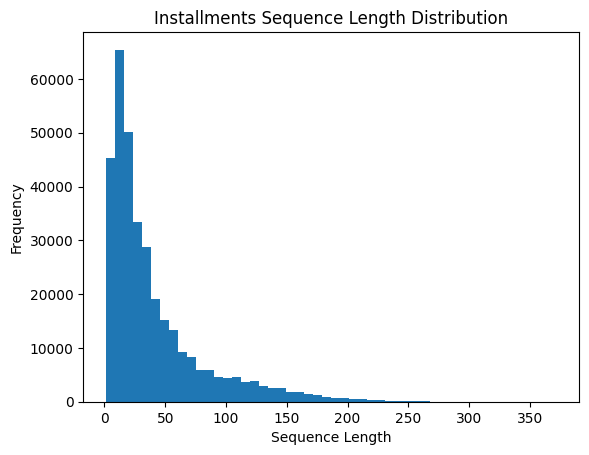

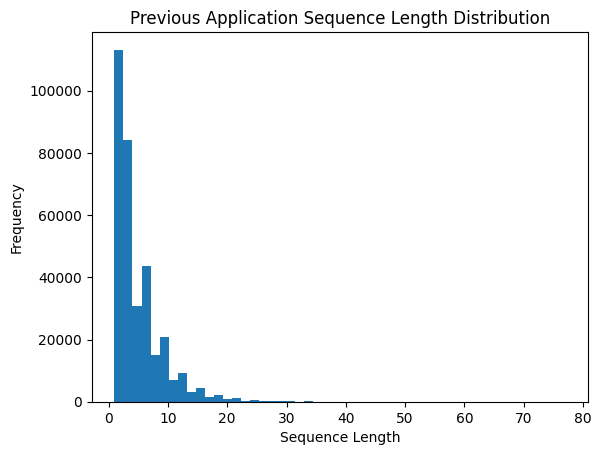

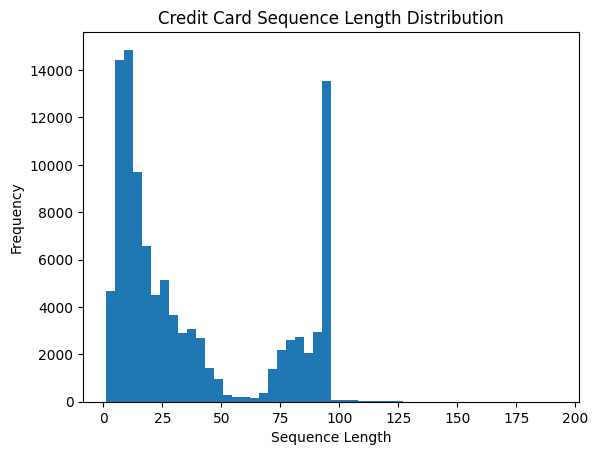

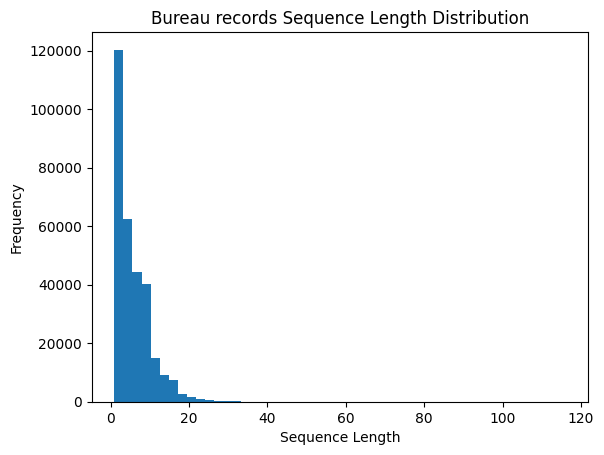

In [8]:
import matplotlib.pyplot as plt

plt.hist(inst_seq_lengths, bins=50)
plt.title("Installments Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

plt.hist(prev_seq_lengths, bins=50)
plt.title("Previous Application Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

plt.hist(cc_seq_lengths, bins=50)
plt.title("Credit Card Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

plt.hist(bureau_seq_lengths, bins=50)
plt.title("Bureau records Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

## CNN-LSTM

### Model 1(Basic model) - test

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.models import Model

# Installments Sequence Input
inst_input = Input(shape=(300, 5), name='installments_input')
x_inst = Conv1D(filters=64, kernel_size=3, activation='relu')(inst_input)
x_inst = MaxPooling1D(pool_size=2)(x_inst)
x_inst = LSTM(64, return_sequences=False)(x_inst)

# Previous Applications Sequence Input
prev_input = Input(shape=(50, 7), name='previous_input')
x_prev = Conv1D(filters=32, kernel_size=2, activation='relu')(prev_input)
x_prev = MaxPooling1D(pool_size=2)(x_prev)
x_prev = LSTM(32, return_sequences=False)(x_prev)

# Credit Card Balance Sequence Input
cc_input = Input(shape=(150, 5), name='creditcard_input')
x_cc = Conv1D(filters=64, kernel_size=3, activation='relu')(cc_input)
x_cc = MaxPooling1D(pool_size=2)(x_cc)
x_cc = LSTM(64, return_sequences=False)(x_cc)

# Bureau Sequence Input
bureau_input = Input(shape=(50, 5), name='bureau_input')
x_bureau = Conv1D(filters=32, kernel_size=2, activation='relu')(bureau_input)
x_bureau = MaxPooling1D(pool_size=2)(x_bureau)
x_bureau = LSTM(32, return_sequences=False)(x_bureau)

# Concatenate all processed sequences
concatenated = Concatenate()([x_inst, x_prev, x_cc, x_bureau])

# Fully connected layers
dense = Dense(128, activation='relu')(concatenated)
dense = Dropout(0.3)(dense)
dense = Dense(64, activation='relu')(dense)
dense = Dropout(0.3)(dense)

# Output layer (binary classification)
output = Dense(1, activation='sigmoid')(dense)

# Model definition
model = Model(inputs=[inst_input, prev_input, cc_input, bureau_input], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Model summary
model.summary()

# Training (example, adjust epochs and batch size according to your resources)
history = model.fit(
    X, y,
    validation_split=0.2,
    epochs=20,
    batch_size=128
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 installments_input (InputL  [(None, 300, 5)]             0         []                            
 ayer)                                                                                            
                                                                                                  
 previous_input (InputLayer  [(None, 50, 7)]              0         []                            
 )                                                                                                
                                                                                                  
 creditcard_input (InputLay  [(None, 150, 5)]             0         []                            
 er)                                                                                          

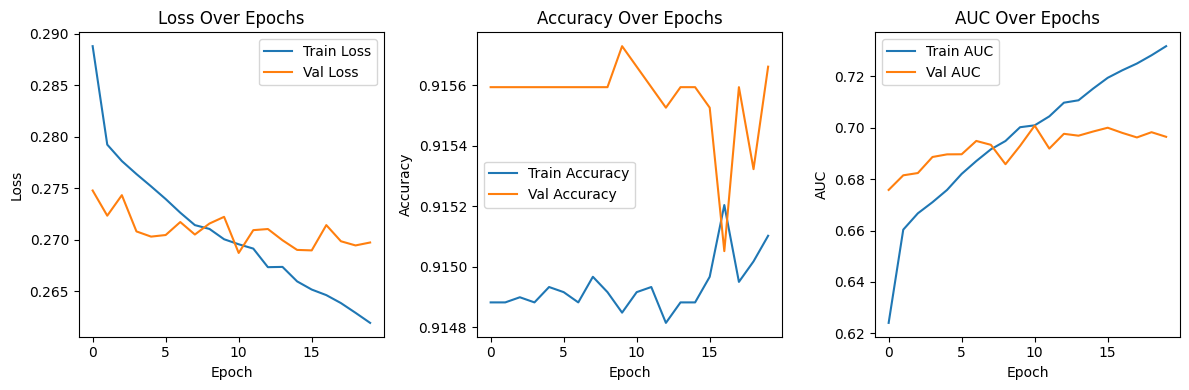

In [10]:
# Convert history to DataFrame (replace with actual `history.history` in real run)
history_df = pd.DataFrame(history.history)

# Plot training vs validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 3, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training vs validation AUC
plt.subplot(1, 3, 3)
plt.plot(history_df['auc'], label='Train AUC')
plt.plot(history_df['val_auc'], label='Val AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

577/577 [==============================] - 56s 94ms/step
Classification Report:
              precision    recall  f1-score   support

  No Default       0.92      1.00      0.96     67538
     Default       0.64      0.01      0.02      6272

    accuracy                           0.92     73810
   macro avg       0.78      0.51      0.49     73810
weighted avg       0.89      0.92      0.88     73810



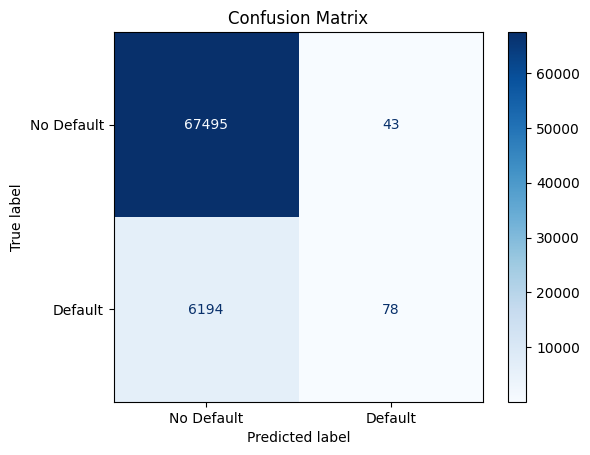

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities and convert to binary predictions
y_pred_prob = model.predict(X, batch_size=128)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(y, y_pred, target_names=["No Default", "Default"]))

# Display confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default", "Default"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Model 2(balanced data) - test

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# Installments Sequence Input
inst_input = Input(shape=(100, 5), name='installments_input')
x_inst = Conv1D(filters=64, kernel_size=3, activation='relu')(inst_input)
x_inst = MaxPooling1D(pool_size=2)(x_inst)
x_inst = LSTM(64, return_sequences=False)(x_inst)

# Previous Applications Sequence Input
prev_input = Input(shape=(100, 7), name='previous_input')
x_prev = Conv1D(filters=32, kernel_size=2, activation='relu')(prev_input)
x_prev = MaxPooling1D(pool_size=2)(x_prev)
x_prev = LSTM(32, return_sequences=False)(x_prev)

# Credit Card Balance Sequence Input
cc_input = Input(shape=(100, 5), name='creditcard_input')
x_cc = Conv1D(filters=64, kernel_size=3, activation='relu')(cc_input)
x_cc = MaxPooling1D(pool_size=2)(x_cc)
x_cc = LSTM(64, return_sequences=False)(x_cc)

# Bureau Sequence Input
bureau_input = Input(shape=(100, 5), name='bureau_input')
x_bureau = Conv1D(filters=32, kernel_size=2, activation='relu')(bureau_input)
x_bureau = MaxPooling1D(pool_size=2)(x_bureau)
x_bureau = LSTM(32, return_sequences=False)(x_bureau)

# Concatenate all processed sequences
concatenated = Concatenate()([x_inst, x_prev, x_cc, x_bureau])

# Fully connected layers
dense = Dense(128, activation='relu')(concatenated)
dense = Dropout(0.3)(dense)
dense = Dense(64, activation='relu')(dense)
dense = Dropout(0.3)(dense)

# Output layer (binary classification)
output = Dense(1, activation='sigmoid')(dense)

# Model definition
model_1 = Model(inputs=[inst_input, prev_input, cc_input, bureau_input], outputs=output)

# Compile the model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Model summary
model_1.summary()

# Training (with class weights to handle imbalance)


early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=6,
    restore_best_weights=True,
    mode='max'
)

history = model_1.fit(
    X, y,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    class_weight=class_weights,
   # callbacks=[early_stopping]
)

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
# Convert history to DataFrame (replace with actual `history.history` in real run)
history_df = pd.DataFrame(history.history)

# Plot training vs validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 3, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training vs validation AUC
plt.subplot(1, 3, 3)
plt.plot(history_df['auc'], label='Train AUC')
plt.plot(history_df['val_auc'], label='Val AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities and convert to binary predictions
y_pred_prob = model_1.predict(X, batch_size=128)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(y, y_pred, target_names=["No Default", "Default"]))

# Display confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default", "Default"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Model 3 (final cnn + lstm model) 

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# Installments Sequence Input
inst_input = Input(shape=(300, 5), name='installments_input')
x_inst = Conv1D(filters=64, kernel_size=3, activation='relu')(inst_input)
x_inst = MaxPooling1D(pool_size=2)(x_inst)
x_inst = LSTM(64, return_sequences=False)(x_inst)

# Previous Applications Sequence Input
prev_input = Input(shape=(50, 7), name='previous_input')
x_prev = Conv1D(filters=64, kernel_size=3, activation='relu')(prev_input)
x_prev = MaxPooling1D(pool_size=2)(x_prev)
x_prev = LSTM(32, return_sequences=False)(x_prev)

# Credit Card Balance Sequence Input
cc_input = Input(shape=(150, 5), name='creditcard_input')
x_cc = Conv1D(filters=64, kernel_size=3, activation='relu')(cc_input)
x_cc = MaxPooling1D(pool_size=2)(x_cc)
x_cc = LSTM(64, return_sequences=False)(x_cc)

# Bureau Sequence Input
bureau_input = Input(shape=(50, 5), name='bureau_input')
x_bureau = Conv1D(filters=64, kernel_size=3, activation='relu')(bureau_input)
x_bureau = MaxPooling1D(pool_size=2)(x_bureau)
x_bureau = LSTM(32, return_sequences=False)(x_bureau)

# Concatenate all processed sequences
concatenated = Concatenate()([x_inst, x_prev, x_cc, x_bureau])

# Fully connected layers
dense = Dense(128, activation='relu')(concatenated)
dense = Dropout(0.3)(dense)
dense = Dense(64, activation='relu')(dense)
dense = Dropout(0.3)(dense)

# Output layer (binary classification)
output = Dense(1, activation='sigmoid')(dense)

# Model definition
model_1 = Model(inputs=[inst_input, prev_input, cc_input, bureau_input], outputs=output)

# Compile the model
model_1.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Model summary
model_1.summary()

# Training (with class weights to handle imbalance)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=5,
    min_lr=1e-10,
    mode='max'
)

# 3) Include them in your fit call
history = model_1.fit(
    X, y,
    validation_split=0.2,
    epochs=500,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 installments_input (InputL  [(None, 300, 5)]             0         []                            
 ayer)                                                                                            
                                                                                                  
 previous_input (InputLayer  [(None, 50, 7)]              0         []                            
 )                                                                                                
                                                                                                  
 creditcard_input (InputLay  [(None, 150, 5)]             0         []                            
 er)                                                                                          

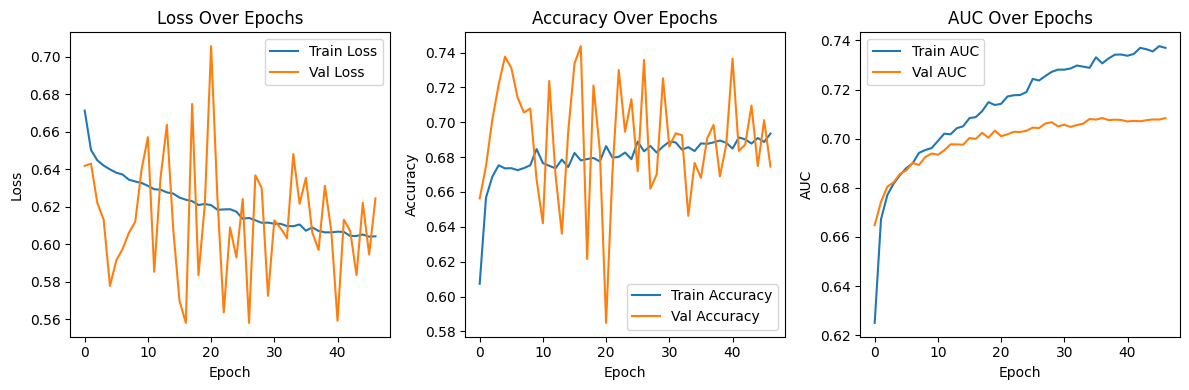

In [9]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

# Plot training vs validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 3, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training vs validation AUC
plt.subplot(1, 3, 3)
plt.plot(history_df['auc'], label='Train AUC')
plt.plot(history_df['val_auc'], label='Val AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

577/577 [==============================] - 38s 63ms/step
Classification Report:
              precision    recall  f1-score   support

  No Default       0.95      0.70      0.81     67538
     Default       0.16      0.64      0.26      6272

    accuracy                           0.69     73810
   macro avg       0.56      0.67      0.53     73810
weighted avg       0.89      0.69      0.76     73810



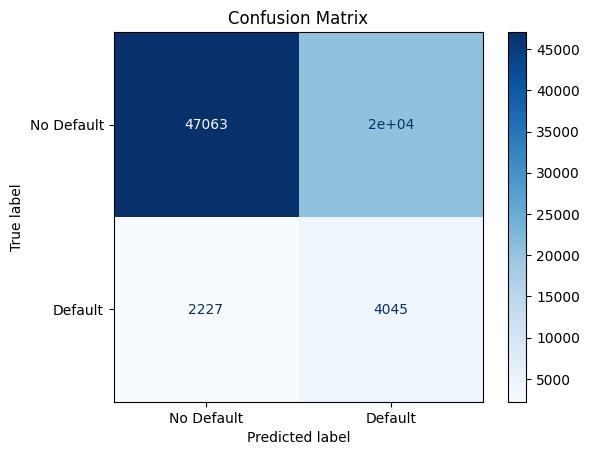

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities and convert to binary predictions
y_pred_prob = model_1.predict(X, batch_size=128)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(y, y_pred, target_names=["No Default", "Default"]))

# Display confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default", "Default"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [11]:
model_1.save("model_credit_risk.h5")

D:\download\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
from tensorflow.keras.models import load_model

model_1 = load_model("model_credit_risk.h5", compile=True)

In [12]:
from sklearn.metrics import roc_auc_score
import pandas as pd

def ablation_auc(model, X_full, y_true, ablate_key):
    X_mod = X_full.copy()
    X_mod[ablate_key] = np.zeros_like(X_mod[ablate_key])
    y_pred = model.predict(X_mod).ravel()
    return roc_auc_score(y_true, y_pred)

ablation_results = []
for key in X.keys():
    auc = ablation_auc(model_1, X, y, key)
    ablation_results.append((key, auc))

# Summary table
df_ablation = pd.DataFrame(ablation_results, columns=["Input Component", "AUC after Ablation"])
df_ablation.sort_values(by="AUC after Ablation", ascending=False, inplace=True)
print(df_ablation)

2307/2307 [==============================] - 173s 75ms/step
      Input Component  AUC after Ablation
3        bureau_input            0.710704
1      previous_input            0.704811
0  installments_input            0.698141
2    creditcard_input            0.686730


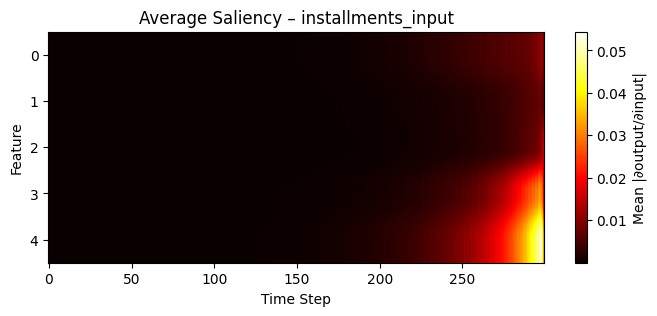

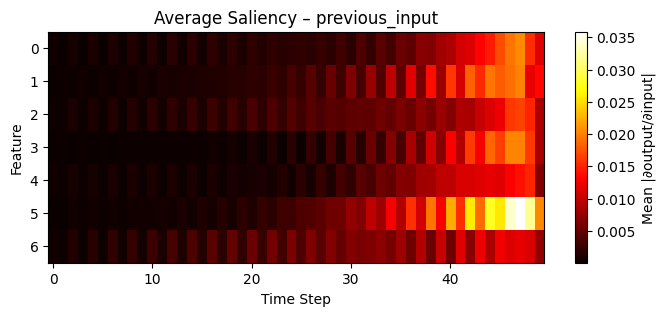

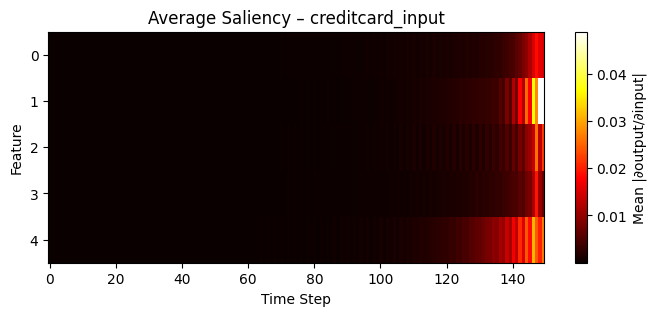

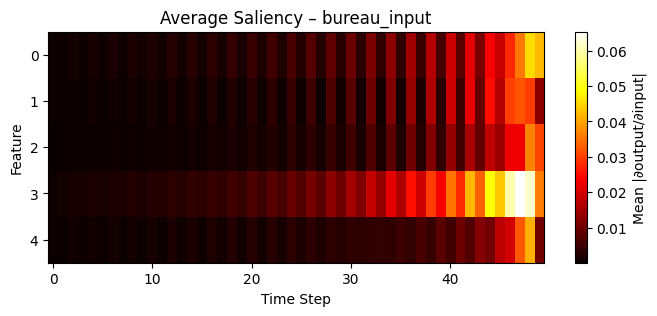

In [13]:
import numpy as np
import tensorflow as tf

def compute_saliency_batch(model, X, sample_indices):
    """Compute and return mean absolute gradients per branch."""
    sums = {k: np.zeros_like(X[k][0]) for k in X}      # shape=(time,features)
    for i in sample_indices:
        inp = {k: tf.convert_to_tensor(X[k][i:i+1]) for k in X}
        with tf.GradientTape() as tape:
            for v in inp.values():
                tape.watch(v)
            pred = model(inp, training=False)
        grads = tape.gradient(pred, inp)
        for k, g in grads.items():
            sums[k] += np.abs(g.numpy().squeeze())
    # average
    means = {k: sums[k] / len(sample_indices) for k in sums}
    return means

# Example: pick 1000 random samples
idxs = np.random.choice(len(y), size=1000, replace=False)
mean_sal = compute_saliency_batch(model_1, X, idxs)

# Plot aggregated saliency heatmap per branch
import matplotlib.pyplot as plt
for k, mat in mean_sal.items():
    plt.figure(figsize=(8,3))
    plt.imshow(mat.T, aspect='auto', cmap='hot')
    plt.title(f"Average Saliency – {k}")
    plt.xlabel("Time Step")
    plt.ylabel("Feature")
    plt.colorbar(label="Mean |∂output/∂input|")
    plt.show()

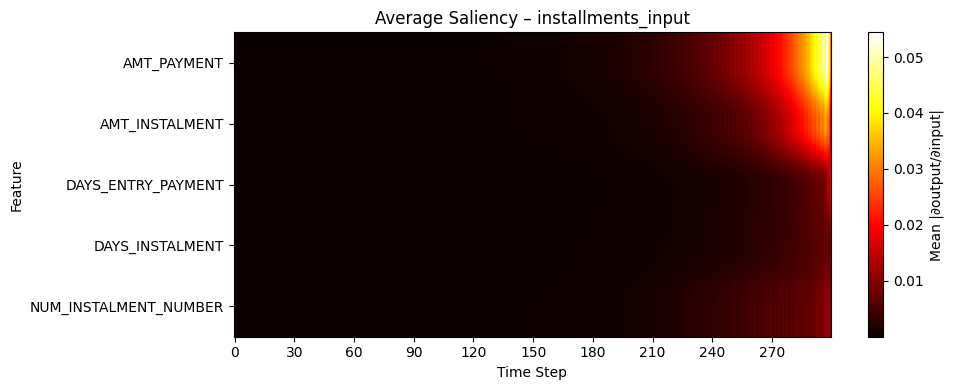

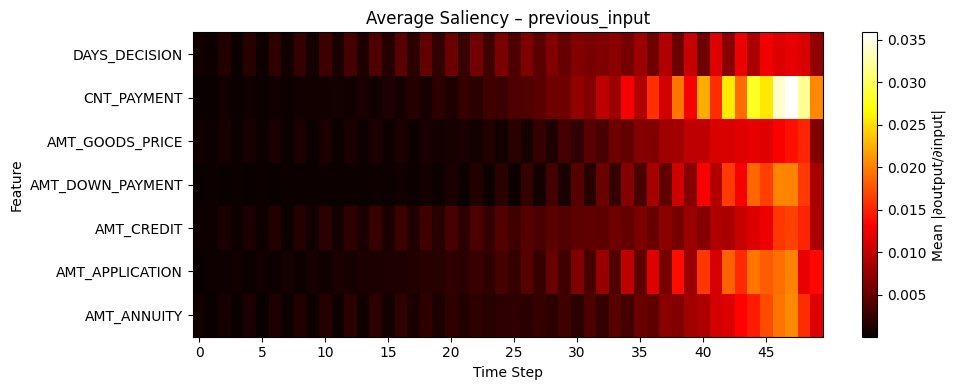

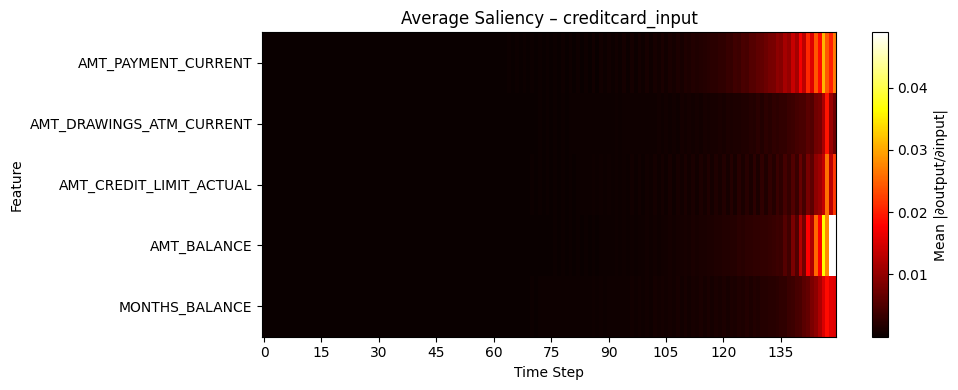

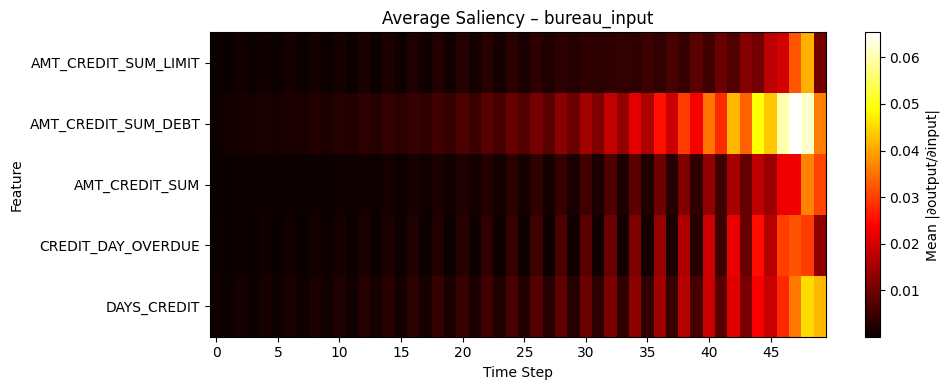

In [32]:
import matplotlib.pyplot as plt

# Your feature name mappings, in the exact order used in each stream:
feature_names = {
    'installments_input': ['NUM_INSTALMENT_NUMBER','DAYS_INSTALMENT',
                           'DAYS_ENTRY_PAYMENT','AMT_INSTALMENT','AMT_PAYMENT'],
    'previous_input':     ['AMT_ANNUITY','AMT_APPLICATION','AMT_CREDIT',
                           'AMT_DOWN_PAYMENT','AMT_GOODS_PRICE','CNT_PAYMENT','DAYS_DECISION'],
    'creditcard_input':   ['MONTHS_BALANCE','AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL',
                           'AMT_DRAWINGS_ATM_CURRENT','AMT_PAYMENT_CURRENT'],
    'bureau_input':       ['DAYS_CREDIT','CREDIT_DAY_OVERDUE','AMT_CREDIT_SUM',
                           'AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT']
}

for branch_name, mat in mean_sal.items():
    T, F = mat.shape  # T = time steps, F = features
    plt.figure(figsize=(10, 4))
    plt.imshow(mat.T, aspect='auto', cmap='hot', origin='lower')
    plt.title(f"Average Saliency – {branch_name}")
    plt.xlabel("Time Step")
    plt.ylabel("Feature")

    # Y‑axis: feature names
    names = feature_names[branch_name]
    plt.yticks(ticks=np.arange(len(names)), labels=names)

    # X‑axis: show only a few tick labels to avoid clutter
    max_ticks = 10
    step = max(1, T // max_ticks)
    xt = np.arange(0, T, step)
    plt.xticks(ticks=xt, labels=xt)

    plt.colorbar(label="Mean |∂output/∂input|", orientation='vertical')
    plt.tight_layout()
    plt.show()

## LSTM AND BILSTM

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ---- class weights (robust mapping to actual labels) ----
classes = np.unique(y)
cw_array = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = {int(c): float(w) for c, w in zip(classes, cw_array)}

# ---- builder ----
def build_model(lstm_variant="lstm", lr=1e-4):
    """
    lstm_variant: 'lstm' or 'bilstm'
    """
    def lstm_block(x, units):
        if lstm_variant == "bilstm":
            return Bidirectional(LSTM(units, return_sequences=False))(x)
        else:
            return LSTM(units, return_sequences=False)(x)

    # Inputs
    inst_input   = Input(shape=(300, 5), name='installments_input')
    prev_input   = Input(shape=(50, 7),  name='previous_input')
    cc_input     = Input(shape=(150, 5), name='creditcard_input')
    bureau_input = Input(shape=(50, 5),  name='bureau_input')

    # Shared pattern per branch (Conv -> Pool -> LSTM-like)
    x_inst = Conv1D(64, 3, activation='relu')(inst_input)
    x_inst = MaxPooling1D(2)(x_inst)
    x_inst = lstm_block(x_inst, 64)

    x_prev = Conv1D(64, 3, activation='relu')(prev_input)
    x_prev = MaxPooling1D(2)(x_prev)
    x_prev = lstm_block(x_prev, 32)

    x_cc = Conv1D(64, 3, activation='relu')(cc_input)
    x_cc = MaxPooling1D(2)(x_cc)
    x_cc = lstm_block(x_cc, 64)

    x_bureau = Conv1D(64, 3, activation='relu')(bureau_input)
    x_bureau = MaxPooling1D(2)(x_bureau)
    x_bureau = lstm_block(x_bureau, 32)

    concatenated = Concatenate()([x_inst, x_prev, x_cc, x_bureau])

    dense = Dense(128, activation='relu')(concatenated)
    dense = Dropout(0.3)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dropout(0.3)(dense)

    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[inst_input, prev_input, cc_input, bureau_input], outputs=output)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# ---- callbacks (same for both runs) ----
early_stopping = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, min_lr=1e-10, mode='max')

# ---- train LSTM model ----
model_lstm = build_model("lstm", lr=1e-4)
history_lstm = model_lstm.fit(
    X, y,
    validation_split=0.2,  # same split across runs
    epochs=500,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ---- train BiLSTM model ----
model_bilstm = build_model("bilstm", lr=1e-4)
history_bilstm = model_bilstm.fit(
    X, y,
    validation_split=0.2,
    epochs=500,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/500
462/462 [==============================] - 176s 359ms/step - loss: 0.6690 - accuracy: 0.6006 - auc: 0.6331 - val_loss: 0.6140 - val_accuracy: 0.6999 - val_auc: 0.6680 - lr: 1.0000e-04
Epoch 2/500
462/462 [==============================] - 149s 323ms/step - loss: 0.6489 - accuracy: 0.6601 - auc: 0.6693 - val_loss: 0.6030 - val_accuracy: 0.7330 - val_auc: 0.6755 - lr: 1.0000e-04
Epoch 3/500
462/462 [==============================] - 139s 301ms/step - loss: 0.6450 - accuracy: 0.6766 - auc: 0.6762 - val_loss: 0.5998 - val_accuracy: 0.7307 - val_auc: 0.6805 - lr: 1.0000e-04
Epoch 4/500
462/462 [==============================] - 150s 324ms/step - loss: 0.6422 - accuracy: 0.6756 - auc: 0.6816 - val_loss: 0.5892 - val_accuracy: 0.7313 - val_auc: 0.6848 - lr: 1.0000e-04
Epoch 5/500
462/462 [==============================] - 163s 353ms/step - loss: 0.6396 - accuracy: 0.6705 - auc: 0.6854 - val_loss: 0.6239 - val_accuracy: 0.6836 - val_auc: 0.6867 - lr: 1.0000e-04
Epoch 6/500
462/462 

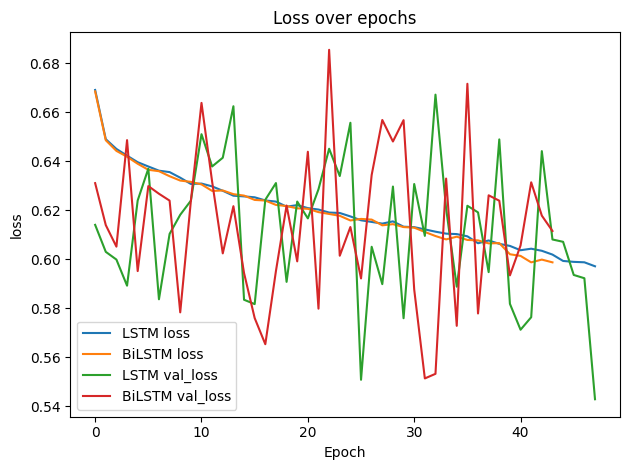

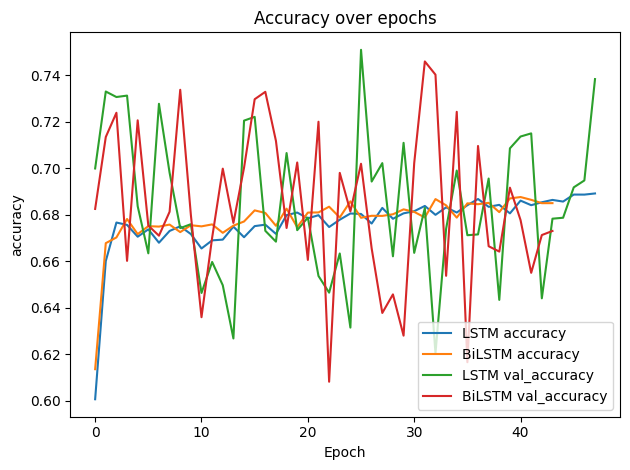

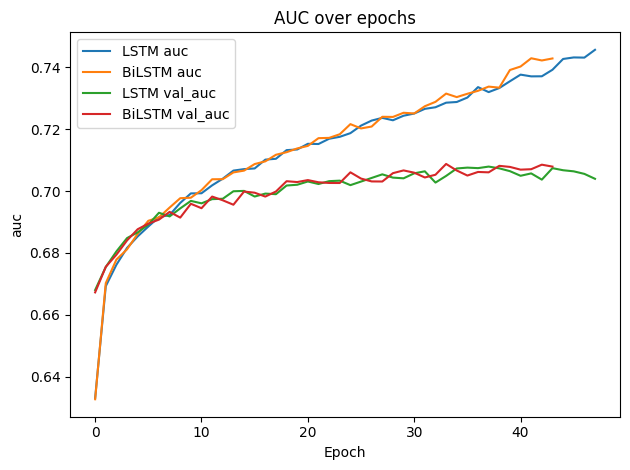


=== LSTM — Validation Metrics ===
AUC: 0.71  |  Accuracy: 0.70  |  Precision: 0.16  |  Recall: 0.61  |  F1: 0.25

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     13516
           1       0.16      0.61      0.25      1246

    accuracy                           0.70     14762
   macro avg       0.56      0.66      0.53     14762
weighted avg       0.88      0.70      0.76     14762

Confusion matrix:
 [[9511 4005]
 [ 489  757]]


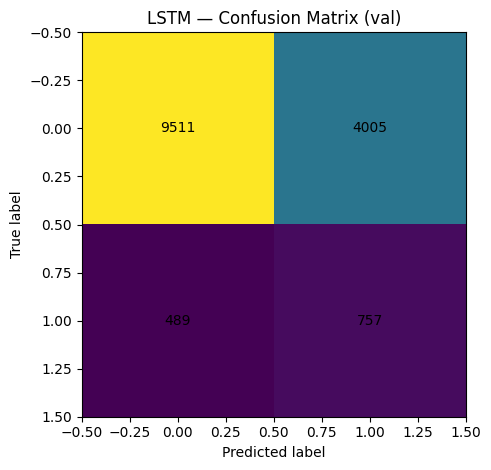


=== BiLSTM — Validation Metrics ===
AUC: 0.71  |  Accuracy: 0.65  |  Precision: 0.15  |  Recall: 0.67  |  F1: 0.24

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.78     13516
           1       0.15      0.67      0.24      1246

    accuracy                           0.65     14762
   macro avg       0.55      0.66      0.51     14762
weighted avg       0.89      0.65      0.73     14762

Confusion matrix:
 [[8821 4695]
 [ 417  829]]


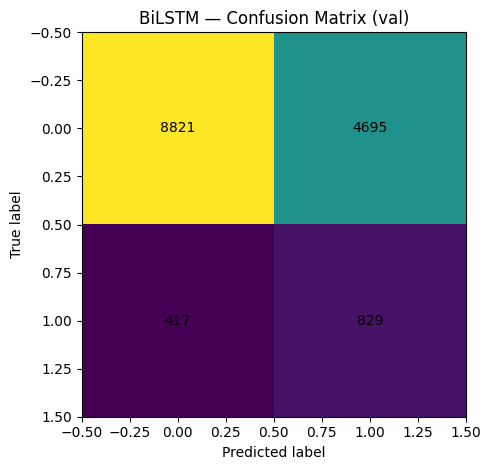

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# ---------- 1) Helper: plot a metric over epochs for both models ----------
def plot_metric(metric_key, hist_lstm, hist_bilstm, title):
    plt.figure()
    # training
    plt.plot(hist_lstm.history[metric_key], label=f"LSTM {metric_key}")
    plt.plot(hist_bilstm.history[metric_key], label=f"BiLSTM {metric_key}")
    # validation (prefixed with 'val_')
    val_key = f"val_{metric_key}"
    if val_key in hist_lstm.history and val_key in hist_bilstm.history:
        plt.plot(hist_lstm.history[val_key], label=f"LSTM {val_key}")
        plt.plot(hist_bilstm.history[val_key], label=f"BiLSTM {val_key}")
    plt.xlabel("Epoch")
    plt.ylabel(metric_key)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- 2) Plots: loss, accuracy, AUC ----------
plot_metric("loss", history_lstm, history_bilstm, "Loss over epochs")
plot_metric("accuracy", history_lstm, history_bilstm, "Accuracy over epochs")
plot_metric("auc", history_lstm, history_bilstm, "AUC over epochs")

# ---------- 3) Rebuild the SAME validation slice used by validation_split=0.2 ----------
N = len(y)
val_start = int(np.ceil(N * (1 - 0.2)))  # last 20% are validation for Keras when using validation_split
X_val = {k: v[val_start:] for k, v in X.items()}
y_val = y[val_start:]

# ---------- 4) Evaluate both models on validation ----------
def eval_and_confmat(model, Xv, yv, name="Model", threshold=0.5):
    # Predict
    y_proba = model.predict(Xv, verbose=0).ravel()
    y_pred = (y_proba >= threshold).astype(int)

    # Metrics
    auc = roc_auc_score(yv, y_proba)
    acc = accuracy_score(yv, y_pred)
    prec = precision_score(yv, y_pred, zero_division=0)
    rec = recall_score(yv, y_pred, zero_division=0)
    f1 = f1_score(yv, y_pred, zero_division=0)

    print(f"\n=== {name} — Validation Metrics ===")
    print(f"AUC: {auc:.2f}  |  Accuracy: {acc:.2f}  |  Precision: {prec:.2f}  |  Recall: {rec:.2f}  |  F1: {f1:.2f}")
    print("\nClassification report:")
    print(classification_report(yv, y_pred, digits=2, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(yv, y_pred)
    print("Confusion matrix:\n", cm)

    # Plot confusion matrix (simple imshow, no style/colors set)
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{name} — Confusion Matrix (val)")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.show()

    return {"AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "CM": cm}

res_lstm   = eval_and_confmat(model_lstm,   X_val, y_val, name="LSTM")
res_bilstm = eval_and_confmat(model_bilstm, X_val, y_val, name="BiLSTM")

## Model (including static feature) increase the ability to find default - tests

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

X_static_clean = X_static.drop(columns=['SK_ID_CURR'])
static_feats = X_static_clean.values  # shape = (n_common, n_static_feats)

imputer = SimpleImputer(strategy='median')
scaler  = StandardScaler()

static_array = scaler.fit_transform(imputer.fit_transform(static_feats))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers    import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models    import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils              import class_weight
import numpy as np
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

# -------------------------------------------------
# ASSUME you already have:
#   inst_seq   # np.array (n_samples, 300, 5)
#   prev_seq   # np.array (n_samples,  50, 7)
#   cc_seq     # np.array (n_samples, 150, 5)
#   bureau_seq # np.array (n_samples,  50, 5)
#   X_static   # np.array (n_samples, n_static_features)
#   y          # np.array (n_samples,) with 0/1 labels
# -------------------------------------------------

# 1) Compute class weights
cw_arr = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(cw_arr))

# 2) Sequence Inputs (unchanged)
inst_input = Input(shape=(300, 5), name='installments_input')
x_inst     = Conv1D(64, 3, activation='relu')(inst_input)
x_inst     = MaxPooling1D(2)(x_inst)
x_inst     = LSTM(64)(x_inst)

prev_input = Input(shape=(50, 7), name='previous_input')
x_prev     = Conv1D(32, 2, activation='relu')(prev_input)
x_prev     = MaxPooling1D(2)(x_prev)
x_prev     = LSTM(32)(x_prev)

cc_input   = Input(shape=(150, 5), name='creditcard_input')
x_cc       = Conv1D(64, 3, activation='relu')(cc_input)
x_cc       = MaxPooling1D(2)(x_cc)
x_cc       = LSTM(64)(x_cc)

bureau_input = Input(shape=(50, 5), name='bureau_input')
x_bureau     = Conv1D(32, 2, activation='relu')(bureau_input)
x_bureau     = MaxPooling1D(2)(x_bureau)
x_bureau     = LSTM(32)(x_bureau)

# 3) Static/tabular Input branch (note the trailing comma!)
static_input = Input(shape=(X_static_clean.shape[1],), name='static_input')
x_stat = Dense(64, activation='relu',
               kernel_regularizer=l2(1e-4))(static_input)
x_stat = BatchNormalization()(x_stat)
x_stat = Dropout(0.3)(x_stat)
# 4) Merge all five branches
merged = Concatenate()([x_inst, x_prev, x_cc, x_bureau, x_stat])

# 5) Fully‐connected head
x = Dense(128, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model_1 = Model(
    inputs=[inst_input, prev_input, cc_input, bureau_input, static_input],
    outputs=output
)

# 6) Compile with a lower learning rate
model_1.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
model_1.summary()

# 7) Callbacks
early_stopping = EarlyStopping(
    monitor='val_auc', patience=6, restore_best_weights=True, mode='max'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_auc', factor=0.5, patience=3, min_lr=1e-6, mode='max'
)

# 8) Fit with a dict of all five inputs
history = model_1.fit(
    {
      'installments_input': inst_seq_filtered.astype('float32'),
      'previous_input':     prev_seq_filtered.astype('float32'),
      'creditcard_input':   cc_seq_filtered.astype('float32'),
      'bureau_input':       bureau_seq_filtered.astype('float32'),
      'static_input':       static_array.astype('float32')
    },
    y.astype('float32'),
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 installments_input (InputLayer  [(None, 300, 5)]    0           []                               
 )                                                                                                
                                                                                                  
 previous_input (InputLayer)    [(None, 50, 7)]      0           []                               
                                                                                                  
 creditcard_input (InputLayer)  [(None, 150, 5)]     0           []                               
                                                                                                  
 bureau_input (InputLayer)      [(None, 50, 5)]      0           []                        

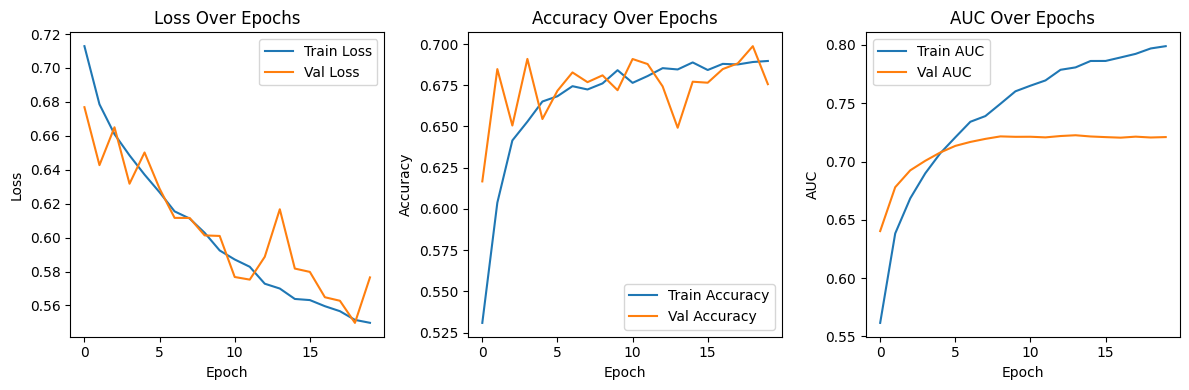

In [27]:
import matplotlib.pyplot as plt
# Convert history to DataFrame (replace with actual `history.history` in real run)
history_df = pd.DataFrame(history.history)

# Plot training vs validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 3, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training vs validation AUC
plt.subplot(1, 3, 3)
plt.plot(history_df['auc'], label='Train AUC')
plt.plot(history_df['val_auc'], label='Val AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

577/577 [==============================] - 89s 150ms/step
              precision    recall  f1-score   support

  No Default       0.97      0.65      0.78     67538
     Default       0.18      0.80      0.29      6272

    accuracy                           0.66     73810
   macro avg       0.57      0.73      0.53     73810
weighted avg       0.90      0.66      0.74     73810



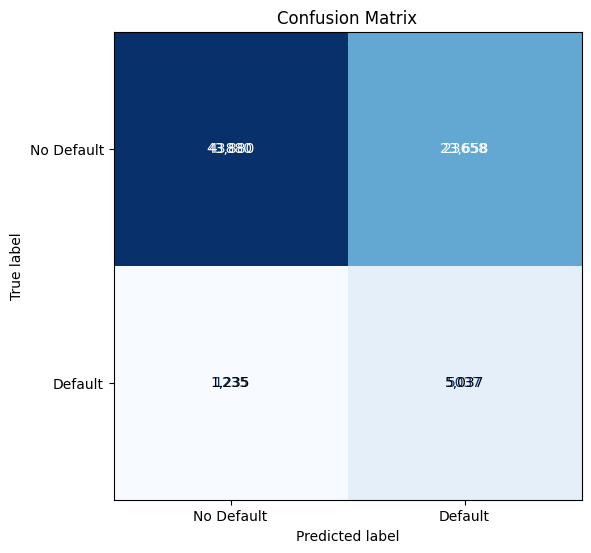

In [28]:
# Build the full input dict:
X_full = {
  'installments_input': inst_seq_filtered.astype('float32'),
  'previous_input':     prev_seq_filtered.astype('float32'),
  'creditcard_input':   cc_seq_filtered.astype('float32'),
  'bureau_input':       bureau_seq_filtered.astype('float32'),
  'static_input':       static_array.astype('float32')
}

# 1) Predict probabilities
y_pred_prob = model_1.predict(X_full, batch_size=128).ravel()

# 2) Convert to binary
y_pred = (y_pred_prob > 0.5).astype(int)

# 3) Classification report
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=['No Default','Default']))

# 4) Confusion matrix display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=['No Default','Default'])

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i,j]:,}", ha='center', va='center',
                color='white' if cm[i,j]>cm.max()/2 else 'black')
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()